In [1]:
from unsloth import FastLanguageModel
from src.llm_helper import invoke_llm, max_seq_length
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.helper import rouge_lsum

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
from datasets import load_dataset

dataset = load_dataset(
    'json', 
    data_files={
        'test': 'data/test.jsonl'
    }
)

In [3]:
ft_model, ft_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "saved_models/full_model2",
    max_seq_length = max_seq_length,
    load_in_4bit = False,
    load_in_8bit = True
)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-3-270m-it",
    max_seq_length = max_seq_length,
    load_in_4bit = False,
    load_in_8bit = True
)

==((====))==  Unsloth 2025.8.9: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.988 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [12]:
def inference(dataset, model, tokenizer):
    res = []
    for example in tqdm(dataset['test']):
        answer = invoke_llm(example['instruction'], model, tokenizer)
        S = rouge_lsum(answer, example['output'])
        res.append([S.precision, S.recall, S.fmeasure, example['instruction'], example['output'], answer])
    return res


In [ ]:
base_test_res = inference(dataset, base_model, base_tokenizer)

100%|██████████| 1000/1000 [13:40<00:00,  1.22it/s]


In [4]:
ft_test_res = inference(dataset, ft_model, ft_tokenizer)

100%|██████████| 1000/1000 [2:16:26<00:00,  8.19s/it] 


In [12]:
def eval(ft_res, base_res, score_idx):
    eval_df = pd.DataFrame(columns = [
        'ft_precision', 'ft_recall', 'ft_fscore', 
        'base_precision', 'base_recall', 'base_fscore',
        'query', 'answer', 
        'pred_ft', 'pred_base'
    ])
    for i in range(len(ft_res)):
        ft_precision, ft_recall, ft_fscore = ft_res[i][0], ft_res[i][1], ft_res[i][2]
        base_precision, base_recall, base_fscore = base_res[i][0], base_res[i][1], base_res[i][2]
        base_score = base_res[i][score_idx]
        query, answer = ft_res[i][3], ft_res[i][4]
        pred_ft = ft_res[i][-1]
        pred_base = base_res[i][-1]
        eval_df.loc[i] = [
            ft_precision, ft_recall, ft_fscore, 
            base_precision, base_recall, base_fscore, 
            query, answer, 
            pred_ft, pred_base
        ]
    return eval_df
    


In [13]:
eval_df = eval(ft_test_res, base_test_res, score_idx=0)
eval_df.to_csv('evaluation/eval_df.csv', index=False)

In [15]:
eval_df.head()

,ft_precision,ft_recall,ft_fscore,base_precision,base_recall,base_fscore,query,answer,pred_ft,pred_base
0,0.212121,0.107143,0.142373,0.216216,0.040816,0.068670,How to diagnose Problems with Smell ?,Scientists have developed tests to determine t...,A doctor or nurse will usually look at the sme...,"Okay, I'm ready to provide information about d..."
1,0.026810,0.212766,0.047619,0.096774,0.063830,0.076923,What are the treatments for aromatase deficien...,These resources address the diagnosis or manag...,There is currently no cure for aromatase defic...,"Okay, I'm ready. Please tell me what treatment..."
2,0.009050,0.042553,0.014925,0.000000,0.000000,0.000000,How to prevent Omsk Hemorrhagic Fever (OHF) ?,There is no vaccine currently available for OH...,The best way to prevent Omsk Hemorrhagic Fever...,NaN
3,0.500000,0.043668,0.080321,0.333333,0.024017,0.044807,What are the stages of Adult Acute Lymphoblast...,Key Points\n - Once adult A...,- The diagnosis of adult acute lymphoblastic l...,"Okay, I'm ready to provide you with the inform..."
4,0.356557,0.348000,0.352227,1.000000,0.020000,0.039216,What are the symptoms of Follicle-stimulating ...,What are the signs and symptoms of Follicle-st...,What are the signs and symptoms of Follicle-st...,"Follicle-stimulating hormone deficiency, isola..."


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

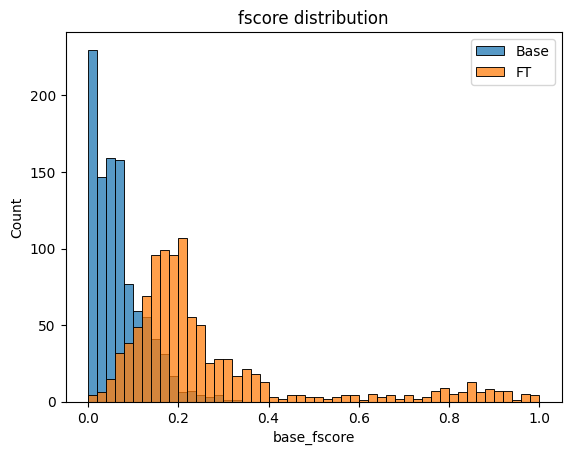

In [23]:
bins = np.linspace(0, 1.0, 51)
sns.histplot(eval_df['base_fscore'], bins=bins, label='Base')
sns.histplot(eval_df['ft_fscore'], bins=bins, label='FT')
plt.title('fscore distribution')
plt.legend()
plt.show()


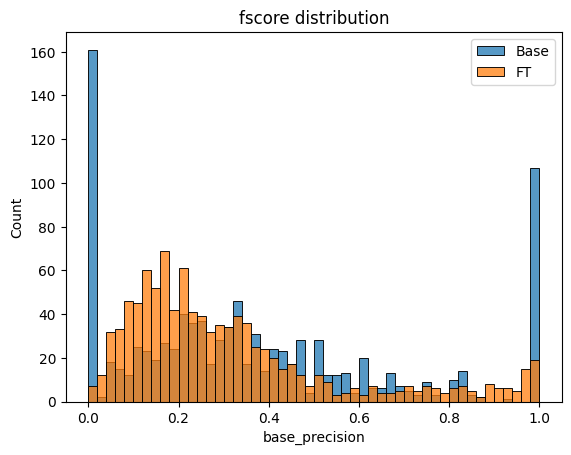

In [ ]:
bins = np.linspace(0, 1.0, 51)
sns.histplot(eval_df['base_precision'], bins=bins, label='Base')
sns.histplot(eval_df['ft_precision'], bins=bins, label='FT')
plt.title('precision distribution')
plt.legend()
plt.show()


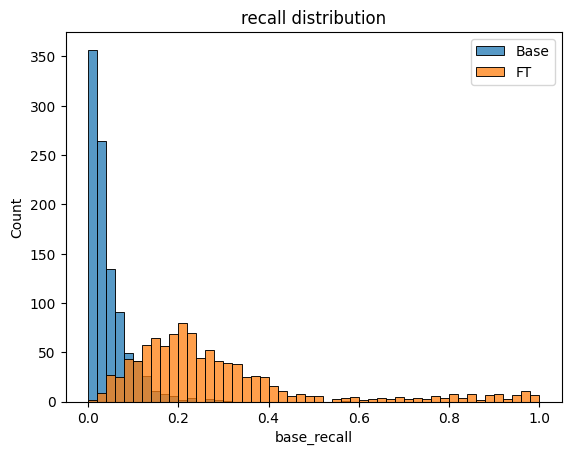

In [26]:
bins = np.linspace(0, 1.0, 51)
sns.histplot(eval_df['base_recall'], bins=bins, label='Base')
sns.histplot(eval_df['ft_recall'], bins=bins, label='FT')
plt.title('recall distribution')
plt.legend()
plt.show()
